<center>

# SIR with Mobility

</center>

In [133]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import re
from random import randint as rint
from scipy.integrate import odeint
from warnings import filterwarnings as fw

In [134]:
fw('ignore')

## Epidemic dynamics on metapopulation networks

Metapopulation models have been a powerful tool for both theorizing and simulating ``epidemic dynamics``. In
a metapopulation model, one considers a network composed of subpopulations and their pairwise connections,
and individuals are assumed to migrate from one subpopulation to another obeying a given mobility rule. While
how different mobility rules affect epidemic dynamics in metapopulation models has been studied, there have been
relatively few efforts on comparison of the effects of simple (i.e., unbiased) random walks and more complex
mobility rules. 

A metapopulation model assumes that a population of individuals is distributed over subpopulations, which correspond to the geographical locations, such as local gathering places, cities, or counties. On the microscopic scale, the individuals are assumed to be fully mixed within each subpopulation. An infectious individual infects each susceptible individual in the same subpopulation with the same rate/probability. This assumption is practical in the absence of detailed data on the structure of interactions among the individuals within each subpopulation. On the macroscopic scale, the individuals traverse edges in the network to travel from one subpopulation to another according to a mobility rule.

## SIR without mobility

A simple mathematical description of the spread of a disease in a population is the so-called SIR model, which divides the (fixed) population of $N$ individuals into three ``compartments`` which may vary as a function of time, $t$:

The SIR model describes the change in the population of each of these compartments in terms of two parameters, β and $\gamma$. $\beta$ describes the ``effective contact rate of the disease``: **an infected individual comes into contact with** $\beta N$ **other individuals per unit time (of which the fraction that are susceptible to contracting the disease is** $\frac{S}{N}$. $\gamma$ **is the** ``mean recovery rate``: **that is,** $\frac{1}{\gamma}$ **is the mean period of time during which an infected individual can pass it on.**

The differential equations describing this model were first derived by ``Kermack and McKendrick`` [Proc. R. Soc. A, 115, 772 (1927)]:

$$\frac{dS}{dt} = -\frac{\beta I S}{N},$$ 
$$\frac{dI}{dt} = \frac{\beta I S}{N} - \gamma I,$$ 
$$\frac{dR}{dt} = \gamma I.$$


<center>

![sir](SIRmodel.jpeg)

</center>

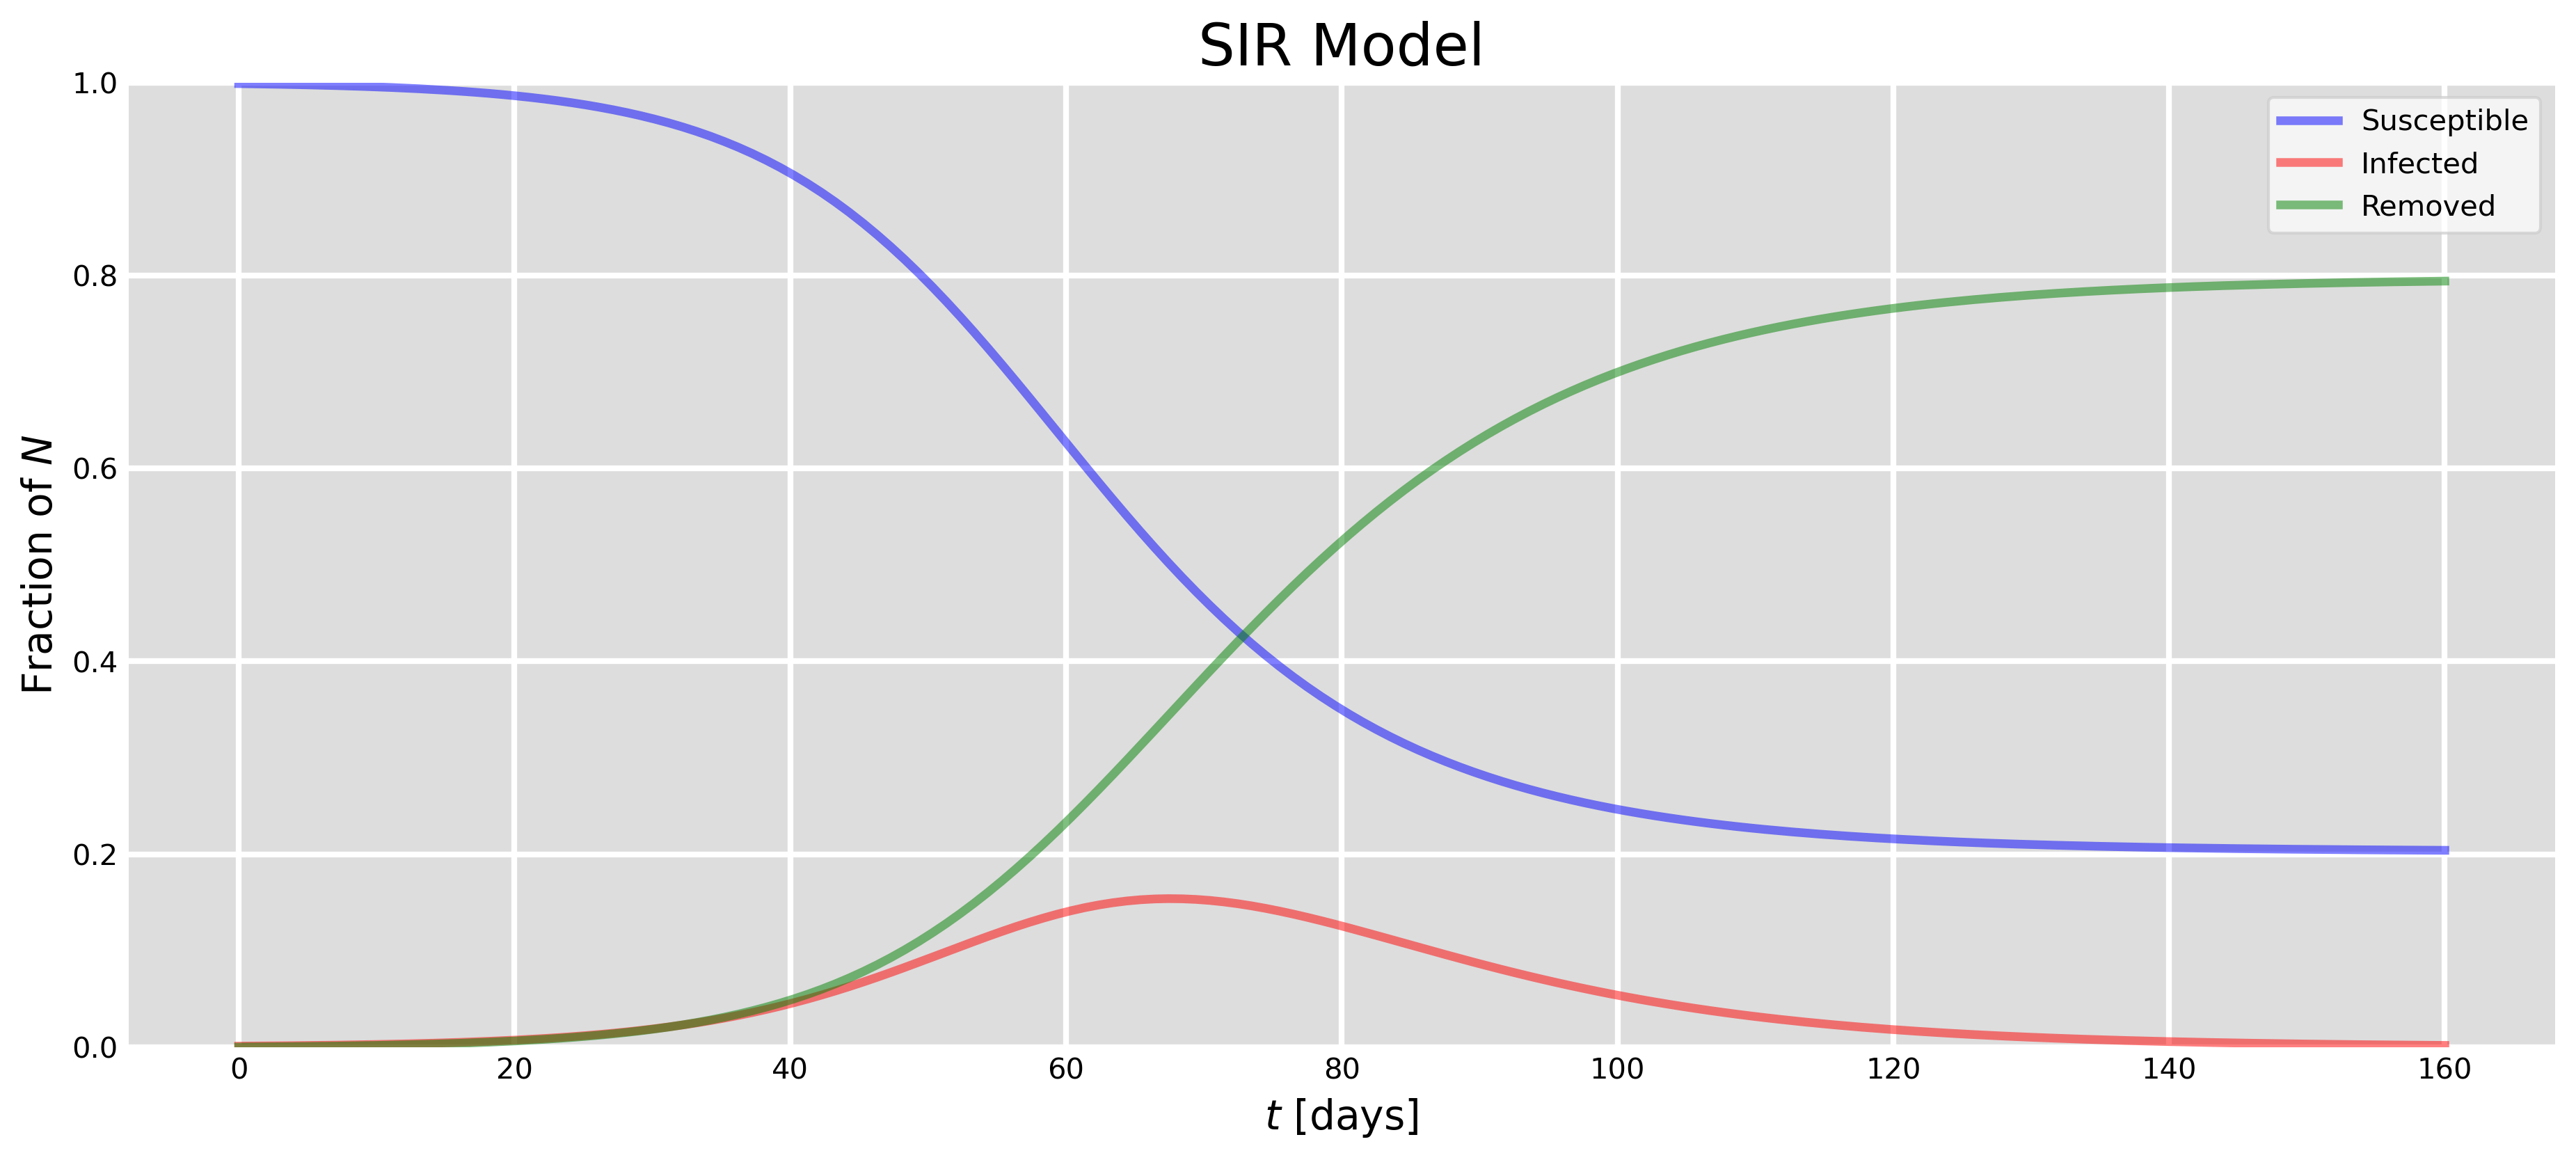

In [135]:
# Total population, N.
N = 1000
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.2, 1./10 
# A grid of time points (in days)
t = np.linspace(0, 160, 160)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(figsize=(15, 6), facecolor='w')
fig.dpi = 300

ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S / N, 'b', alpha=0.5, lw=3, label='Susceptible')
ax.plot(t, I / N, 'r', alpha=0.5, lw=3, label='Infected')
ax.plot(t, R / N, 'g', alpha=0.5, lw=3, label='Removed')
ax.set_title('SIR Model', fontsize=20)
ax.set_xlabel(r'$t$' + ' [days]', fontsize=14)
ax.set_ylabel('Fraction of ' + r'$N$', fontsize=14)
ax.set_ylim(0,1.)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.7)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

## Metapopulation SIR model - Considering flows of people between populations

In order to understand the geographical diffusion of diseases, one has to combine the microscopic contagion processes with the long-range disease propagation due to human mobility across different spatial scales. In order to tackle this problem, epidemic modeling has relied on reaction-diffusion dynamics in ``metapopulations``. Metapopulations can be thought as nodes of a complex network of spatial patches, where links encode human flows from one place to another and are responsible for between-patch transmission.

<center>

![MetapopSIR](MetaSIR2.jpeg)

</center>

Modeling:

- $M$: number of patches;
- $N$: total number of agents;
- $N_i$: population of the i-th patch;
- At any time $N = \sum_{i} N_i$ (considering the system is closed, without births or deaths);

Let $(m_{ij}) \in \mathbb{R}^{N \times N}$ be the adjacency matrix of a mobility network with $N$ nodes, whose entries correspond to the flow of people from $i$ to $j$. Each node is a patch, with fixed coordinates and a metapopulation. This means each node has its own SIR compartments and their evolution depend not only on the inner population but also on other nodes.

The probability $P_{ij}$ that an agent placed in $i$ moves to $j$ must be proportional to the flux $m_{ij}$ and reads

$$P_{ij} = \frac{m_{ij}}{\sum_{j=1}^{M} m_{ij}}$$


## Our test graph without inflow/outflow - Only for visualization

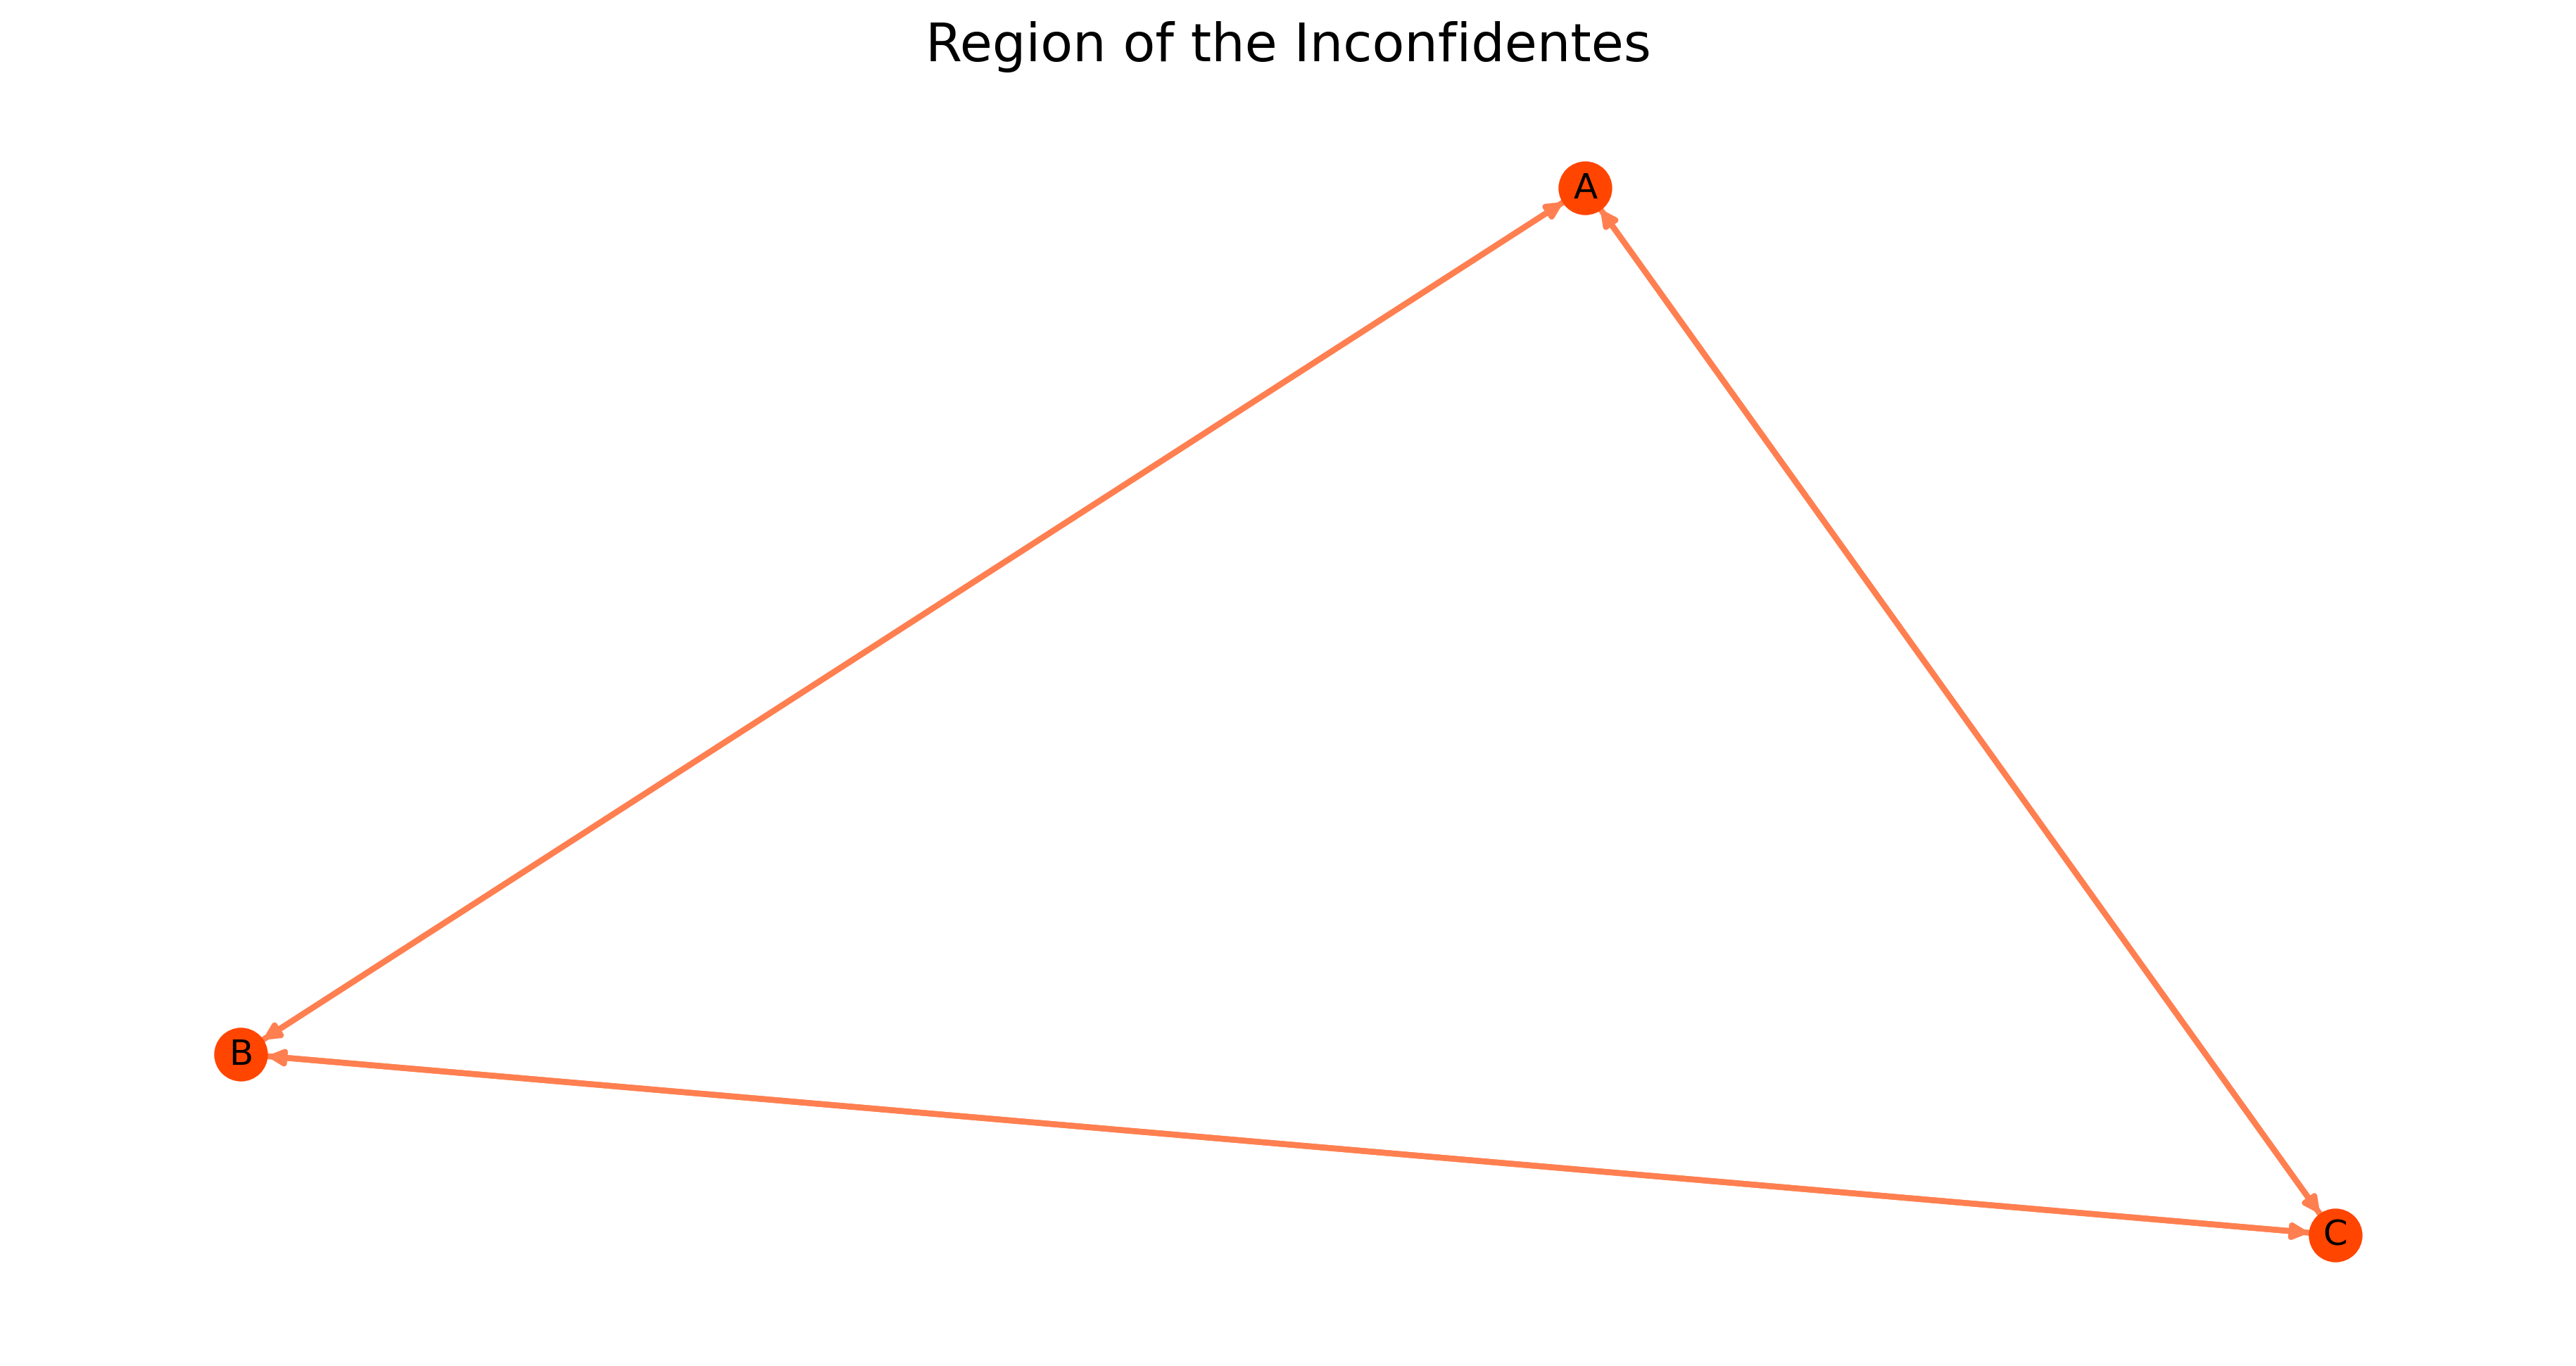

In [136]:
f = plt.figure(figsize=(12, 6), dpi=300)

G = nx.DiGraph()

G.add_edges_from([
    ('A', 'B'),
    ('B', 'A'), 
    ('A', 'C'),
    ('C', 'A'), 
    ('B', 'C'),
    ('C', 'B')
])

nx.set_node_attributes(G, {
    'A' : {
            'label' : 'Antônio Pereira', 
            'N' : 3500
        },
    'B' : {
            'label' : 'Ouro Preto',
            'N' : 74558
        },
    'C' : {
            'label' : 'Mariana',
            'N' : 61288
        }
})

nx.draw(
    G, 
    with_labels=True, 
    width=2, 
    edge_color='coral',
    node_color='orangered', 
    style='solid'
)

plt.title('Region of the Inconfidentes', fontsize=18)
plt.show()
f.savefig('results/Inconfidentes.png')

In [137]:
print(nx.info(G))

print(44 * '-')

for node in G.nodes():
    print('Node', node, '-> Neighbors:', list(G.neighbors(node)), '-> Degree:', len(list(G.neighbors(node))))
    print(f"Node label: {G.nodes[node]['label']}")
    print(f"Node population: {G.nodes[node]['N']}")
    print()

DiGraph with 3 nodes and 6 edges
--------------------------------------------
Node A -> Neighbors: ['B', 'C'] -> Degree: 2
Node label: Antônio Pereira
Node population: 3500

Node B -> Neighbors: ['A', 'C'] -> Degree: 2
Node label: Ouro Preto
Node population: 74558

Node C -> Neighbors: ['A', 'B'] -> Degree: 2
Node label: Mariana
Node population: 61288



## Considering flows of people between populations

|        | $I^{O}$                                                                                           | $I^{D}$                                                                                                                       |
|--------|--------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------------------|
| $S^{O}$ | **(1)**: traditional approach,  infection of susceptibles living in the same place as those infected | **(2)**: infected from other locations who arrived at the destination where will the infection be                                |
| $S^{D}$ | **(3)**: susceptibles who traveled and  were infected by infected people  living at the destination  | **(4)**: susceptible people went to a place  and there they found infected people  who live in another place but went  there too |

$$

\begin{equation} 
\begin{aligned} 
\frac{dS_i}{dt} = - \beta \frac{m_{ii}}{N_i} S_i 
\frac{ \left ( \frac{ m_{ii} }{ N_i } \right ) I_i}{ 
\left ( \frac{ m_{ii} }{ N_i } \right ) N_i }, \;\; j=i, k=j=i
\end{aligned} 
\end{equation}

\\

\begin{equation} 
\begin{aligned} 
\frac{dS_i}{dt} = - \beta \frac{m_{ii}}{N_i} S_i
\frac{ \sum_{ \substack{k=1\\k\neq i}}^N  \left ( \frac{ m_{ki} }{ N_k } \right ) I_k}{ 
 \sum_{ \substack{k=1\\k\neq i}}^N \left ( \frac{ m_{ki} }{ N_k } \right ) N_k }, \;\; j=i
\end{aligned} 
\end{equation}

\\

\begin{equation} 
\begin{aligned} 
\frac{dS_i}{dt} = - \beta \sum_{ \substack{j=1\\j\neq i}}^N \left ( \frac{m_{ij}}{N_i} \right ) S_i \frac{ \left ( \frac{ m_{ij} }{ N_i } \right ) I_i}{ 
\left ( \frac{ m_{ij} }{ N_i } \right ) N_i }, \;\; k=i
\end{aligned} 
\end{equation}

\\

\begin{equation} 
\begin{aligned}
\frac{dS_i}{dt} &= -\beta \sum_{\substack{j=1\\j\neq i}}^N  
\left ( \frac{m_{ij}}{N_i} \right ) S_i 
\frac{ \sum_{\substack{k=1\\k\neq i}}^N  
\left ( \frac{m_{kj}}{N_k} \right ) I_k }{ \sum_{\substack{k=1\\k\neq i}}^N  
\left ( \frac{m_{ki}}{N_k} \right ) N_k }
\end{aligned} 
\end{equation}

$$

## Nodes statuses and auxiliar functions

In [138]:
# Picking only 500 infected person in all the 3 nodes

nodes_statuses = {
    'A' : {
            'S' : np.array([G.nodes['A']['N'] - 500]),
            'I' : np.array([500]),
            'R' : np.array([0]),
            'beta' : .5,
            'gamma' : .4,
            'N' : G.nodes['A']['N'],
            'district_name' : G.nodes['A']['label']
        },
    'B' : {
            'S' : np.array([G.nodes['B']['N'] - 500]),
            'I' : np.array([500]),
            'R' : np.array([0]),
            'beta' : .5,
            'gamma' : .4,
            'N' : G.nodes['B']['N'],
            'district_name' : G.nodes['B']['label']
        },
    'C' : {
            'S' : np.array([G.nodes['C']['N'] - 500]),
            'I' : np.array([500]),
            'R' : np.array([0]),
            'N' : G.nodes['C']['N'],
            'beta' : .5,
            'gamma' : .4,
            'district_name' : G.nodes['C']['label']
        }
}

## Attributes of each node

In [139]:
df = pd.DataFrame(nodes_statuses).T
df[['beta', 'gamma', 'N', 'district_name']].head()

,beta,gamma,N,district_name
A,0.5,0.4,3500,Antônio Pereira
B,0.5,0.4,74558,Ouro Preto
C,0.5,0.4,61288,Mariana


## Generating the OD matrices

**OD** or **Origin-Destination** Matrix is a description of movement in a certain area and is used to assess the demand for transportation. In an OD Matrix each cell is an intersection of a trip from an origin to a destination, and the higher the number of these trips the more this route is in demand.

Since the **nodes** of our graph represent **populations** of districts, respectively its **edges** represent the **flows of individuals** from populations between these locations.

The inflows and outflows compose two separate adjacency matrices. The former presents the number (**integer**) of people that moves from $i$ to $j$, concerning j. Node $j$ tracks the relative inflows from every other node. The outflows behave similarly, but with the distribution of outflows concerning j. Moreover, each node has at most 2 neighbors.

``Note: this OD matrices does not represent the actual flows of these districts, it will only be an estimate.``

In [140]:
def r_flow(node_population):
    return rint(1, node_population + 1)

def migration(node):
    if node == 'A':
        flow = np.array([0, r_flow(G.nodes[node]['N']), r_flow(G.nodes[node]['N'])])
        while sum(flow) >= G.nodes[node]['N']:
            flow = np.array([0, r_flow(G.nodes[node]['N']), r_flow(G.nodes[node]['N'])])
        return flow * 1.0
    elif node == 'B':
        flow = np.array([r_flow(G.nodes[node]['N']), 0, r_flow(G.nodes[node]['N'])])
        while sum(flow) >= G.nodes[node]['N']:
            flow = np.array([r_flow(G.nodes[node]['N']), 0, r_flow(G.nodes[node]['N'])])
        return flow * 1.0
    else:
        flow = np.array([r_flow(G.nodes[node]['N']), r_flow(G.nodes[node]['N']), 0])
        while sum(flow) >= G.nodes[node]['N']:
            flow = np.array([r_flow(G.nodes[node]['N']), r_flow(G.nodes[node]['N']), 0])
        return flow * 1.0

In [141]:
# We will use the time range of one month in days

for time in range(30):
    
    ########################INFLOW############################
    
    OD_matrix = pd.DataFrame(
        {
            'A' : migration('A'),
            'B' : migration('B'),
            'C' : migration('C')
        },
        index=[key for key in nodes_statuses.keys()]
    )
    OD_matrix = OD_matrix.T # We want the transpose of this matrix
    OD_matrix.to_csv(f'data/inflow/OD_matrix_in_{time + 1}.csv', index_label='districts', index=True)

    ########################OUTFLOW############################

    OD_matrix = pd.DataFrame(
        {
            'A' : migration('A'),
            'B' : migration('B'),
            'C' : migration('C')
        },
        index=[key for key in nodes_statuses.keys()]
    )
    OD_matrix = OD_matrix.T # We want the transpose of this matrix
    OD_matrix.to_csv(f'data/outflow/OD_matrix_out_{time + 1}.csv', index_label='districts', index=True)

In [142]:
# Auxiliar function to sort the OD matrices in the folder
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)] 
    return sorted(data, key=alphanum_key)

## Reading the generated flow files to be used later

In [143]:
def get_OD_matrix(data_flows):
    inflow_data = []
    outflow_data = []

    for file_in, file_out in data_flows:
        ##################INFLOWS########################

        data_flow = pd.read_csv('data/inflow/' + file_in)
        data_flow.set_index('districts', inplace=True)
        data_flow = data_flow.to_numpy()
        inflow_data.append(data_flow)
        # g = nx.from_numpy_matrix(data_flows, create_using=nx.DiGraph)

        ##################OUTFLOWS#######################        
        data_flow = pd.read_csv('data/outflow/' + file_out)
        data_flow.set_index('districts', inplace=True)
        data_flow = data_flow.to_numpy()
        outflow_data.append(data_flow)
        # g = nx.from_numpy_matrix(data_flows, create_using=nx.DiGraph)
    
    return zip(inflow_data, outflow_data)

inflow_files = sorted_alphanumeric(os.listdir('data/inflow/'))
outflow_files = sorted_alphanumeric(os.listdir('data/outflow/'))
data_flows = zip(inflow_files, outflow_files)

In [144]:
inflow = []
outflow = []

for _in, _out in get_OD_matrix(data_flows):
    inflow.append(_in)
    outflow.append(_out)

## Model for ODEINT - SIR Model for Metapopulation Networks 

$$

\begin{equation} 
\begin{aligned}
\frac{dS_i}{dt} &= -\beta \sum_{\substack{j=1\\j\neq i}}^N  
\left ( \frac{m_{ij}}{N_i} \right ) S_i 
\frac{ \sum_{\substack{k=1\\k\neq i}}^N  
\left ( \frac{m_{kj}}{N_k} \right ) I_k }{ \sum_{\substack{k=1\\k\neq i}}^N  
\left ( \frac{m_{ki}}{N_k} \right ) N_k }
\end{aligned} 
\end{equation}
\\
\\

\begin{equation} 
\begin{aligned}
\frac{dI_i}{dt} &= \beta \sum_{\substack{j=1\\j\neq i}}^N  
\left ( \frac{m_{ij}}{N_i} \right ) S_i 
\frac{ \sum_{\substack{k=1\\k\neq i}}^N  
\left ( \frac{m_{kj}}{N_k} \right ) I_k }{ \sum_{\substack{k=1\\k\neq i}}^N  
\left ( \frac{m_{ki}}{N_k} \right ) N_k }
- \gamma  I_i 
\end{aligned} 
\end{equation}
\\
\\

\begin{equation} 
\begin{aligned}
\frac{dR_i}{dt} &= \gamma I_i 
\end{aligned} 
\end{equation}

$$

In [145]:
def metaSIR(y, t, nodes_statuses, M):
    '''
    We will need to integrate the system of ordinary differential equations from the above SIR model. 
    The integrator we will use is odeint from the scipy.integrate package.

    ODEINT:
    Solve a system of ordinary differential equations using lsoda from the FORTRAN library odepack.

    Solves the initial value problem for stiff or non-stiff systems of first order ode-s:   

                    dy/dt = func(y, t, ...) [or func(t, y, ...)]

    where y can be a vector.

    WILL RECEIVE:

    func -> callable(y, t, …) or callable(t, y, …) -> metaSIR
    Computes the derivative of y at t. If the signature is callable(t, y, ...), then the argument 
    tfirst must be set True;
    
    y0array -> Initial condition on y (can be a vector) -> y0;
    
    tarray -> A sequence of time points for which to solve for y. The initial value point should 
    be the first element of this sequence. This sequence must be monotonically increasing or monotonically 
    decreasing; repeated values are allowed -> t;
    
    argstuple, optional -> Extra arguments to pass to function -> nodes_statuses (dict with attributes of the nodes), M (OD matrix);

    Our dY_dt will be a one-dimensional array encapsulating S_i, I_i, R_i with i going from 1 to 
    N_patches (Total number of metapops). 

    dY_dt = 
    [
        SA - 0,
        IA - 1,
        RA - 2,

        SB - 3,
        IB - 4,
        RB - 5,
    
        SC - 6,
        IC - 7,
        RC - 8
    ]
    _i -> Auxiliar index for dY_dt -> 3 in 3
    '''
    
    N_patches = len(nodes_statuses) # Total number of metapops
    nodes = [key for key in nodes_statuses.keys()] # Auxiliar list of the nodes
    dY_dt = [] # dS_dt, dI_dt, dR_dt will be stored in this empty stack
    _i = 0

    for i in range(N_patches):
        S = y[_i] # Initial condition of S_i
        I = y[_i + 1] # Initial condition of I_i
        R = y[_i + 2] # Initial condition of R_i
        _i += 3
        beta = nodes_statuses[nodes[i]]['beta'] # beta of Node_i - infection rate
        gamma = nodes_statuses[nodes[i]]['gamma'] # gamma of Node_i - recovery rate
        _sum_j = 0
        for j in range(N_patches):
            _sum_num = 0
            _sum_den = 0
            if j != i:
                for k in range(N_patches):
                    if k != i:
                        _sum_num += (M[k][j] / nodes_statuses[nodes[k]]['N']) * I
                        _sum_den += (M[k][i] / nodes_statuses[nodes[k]]['N']) * nodes_statuses[nodes[k]]['N']  
                _sum_j += (M[i][j] / nodes_statuses[nodes[i]]['N']) * S * (_sum_num / _sum_den)

        dY_dt.append(-beta * _sum_j) # S
        dY_dt.append(beta * _sum_j - gamma * I) # I
        dY_dt.append(gamma * I) # R

    return dY_dt

# Initial conditions of all three nodes
y0 = np.array([
    nodes_statuses['A']['S'][0],
    nodes_statuses['A']['I'][0],
    nodes_statuses['A']['R'][0],
    nodes_statuses['B']['S'][0],
    nodes_statuses['B']['I'][0],
    nodes_statuses['B']['R'][0],
    nodes_statuses['C']['S'][0],
    nodes_statuses['C']['I'][0],
    nodes_statuses['C']['R'][0]
])

# A grid of time points (in days)
t = np.linspace(0, 30, 1000)

# Integrating for M = inflow[0]
ret = odeint(metaSIR, y0, t, args=(nodes_statuses, inflow[0]))

## Auxiliar function to plot and save the figure in results

In [146]:
def plot_metaSIR(t, fig_node, dict_SIR):
    
    '''
    fig_node -> Node 'A', 'B' or 'C'
    dict_SIR -> ret[:, [S_i, I_i or R_i]] -> i : {0..N=8}
    '''
    
    fig = plt.figure(figsize=(15, 6), facecolor='w')
    fig.dpi = 300

    ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
    ax.plot(t, dict_SIR['S'], 'b', alpha=0.5, lw=3, label='Susceptible')
    ax.plot(t, dict_SIR['I'], 'r', alpha=0.5, lw=3, label='Infected')
    ax.plot(t, dict_SIR['R'], 'g', alpha=0.5, lw=3, label='Removed')
    ax.set_title(f'SIR Model - Node ' + fig_node + ' - ' + nodes_statuses[fig_node]['district_name'], fontsize=20)
    ax.set_xlabel(r'$t$' + ' [days]', fontsize=14)
    ax.set_ylabel('Fraction of ' + r'$N_{i}$', fontsize=14)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.7)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show()
    
    return fig.savefig('results/node_' + fig_node + '.png')

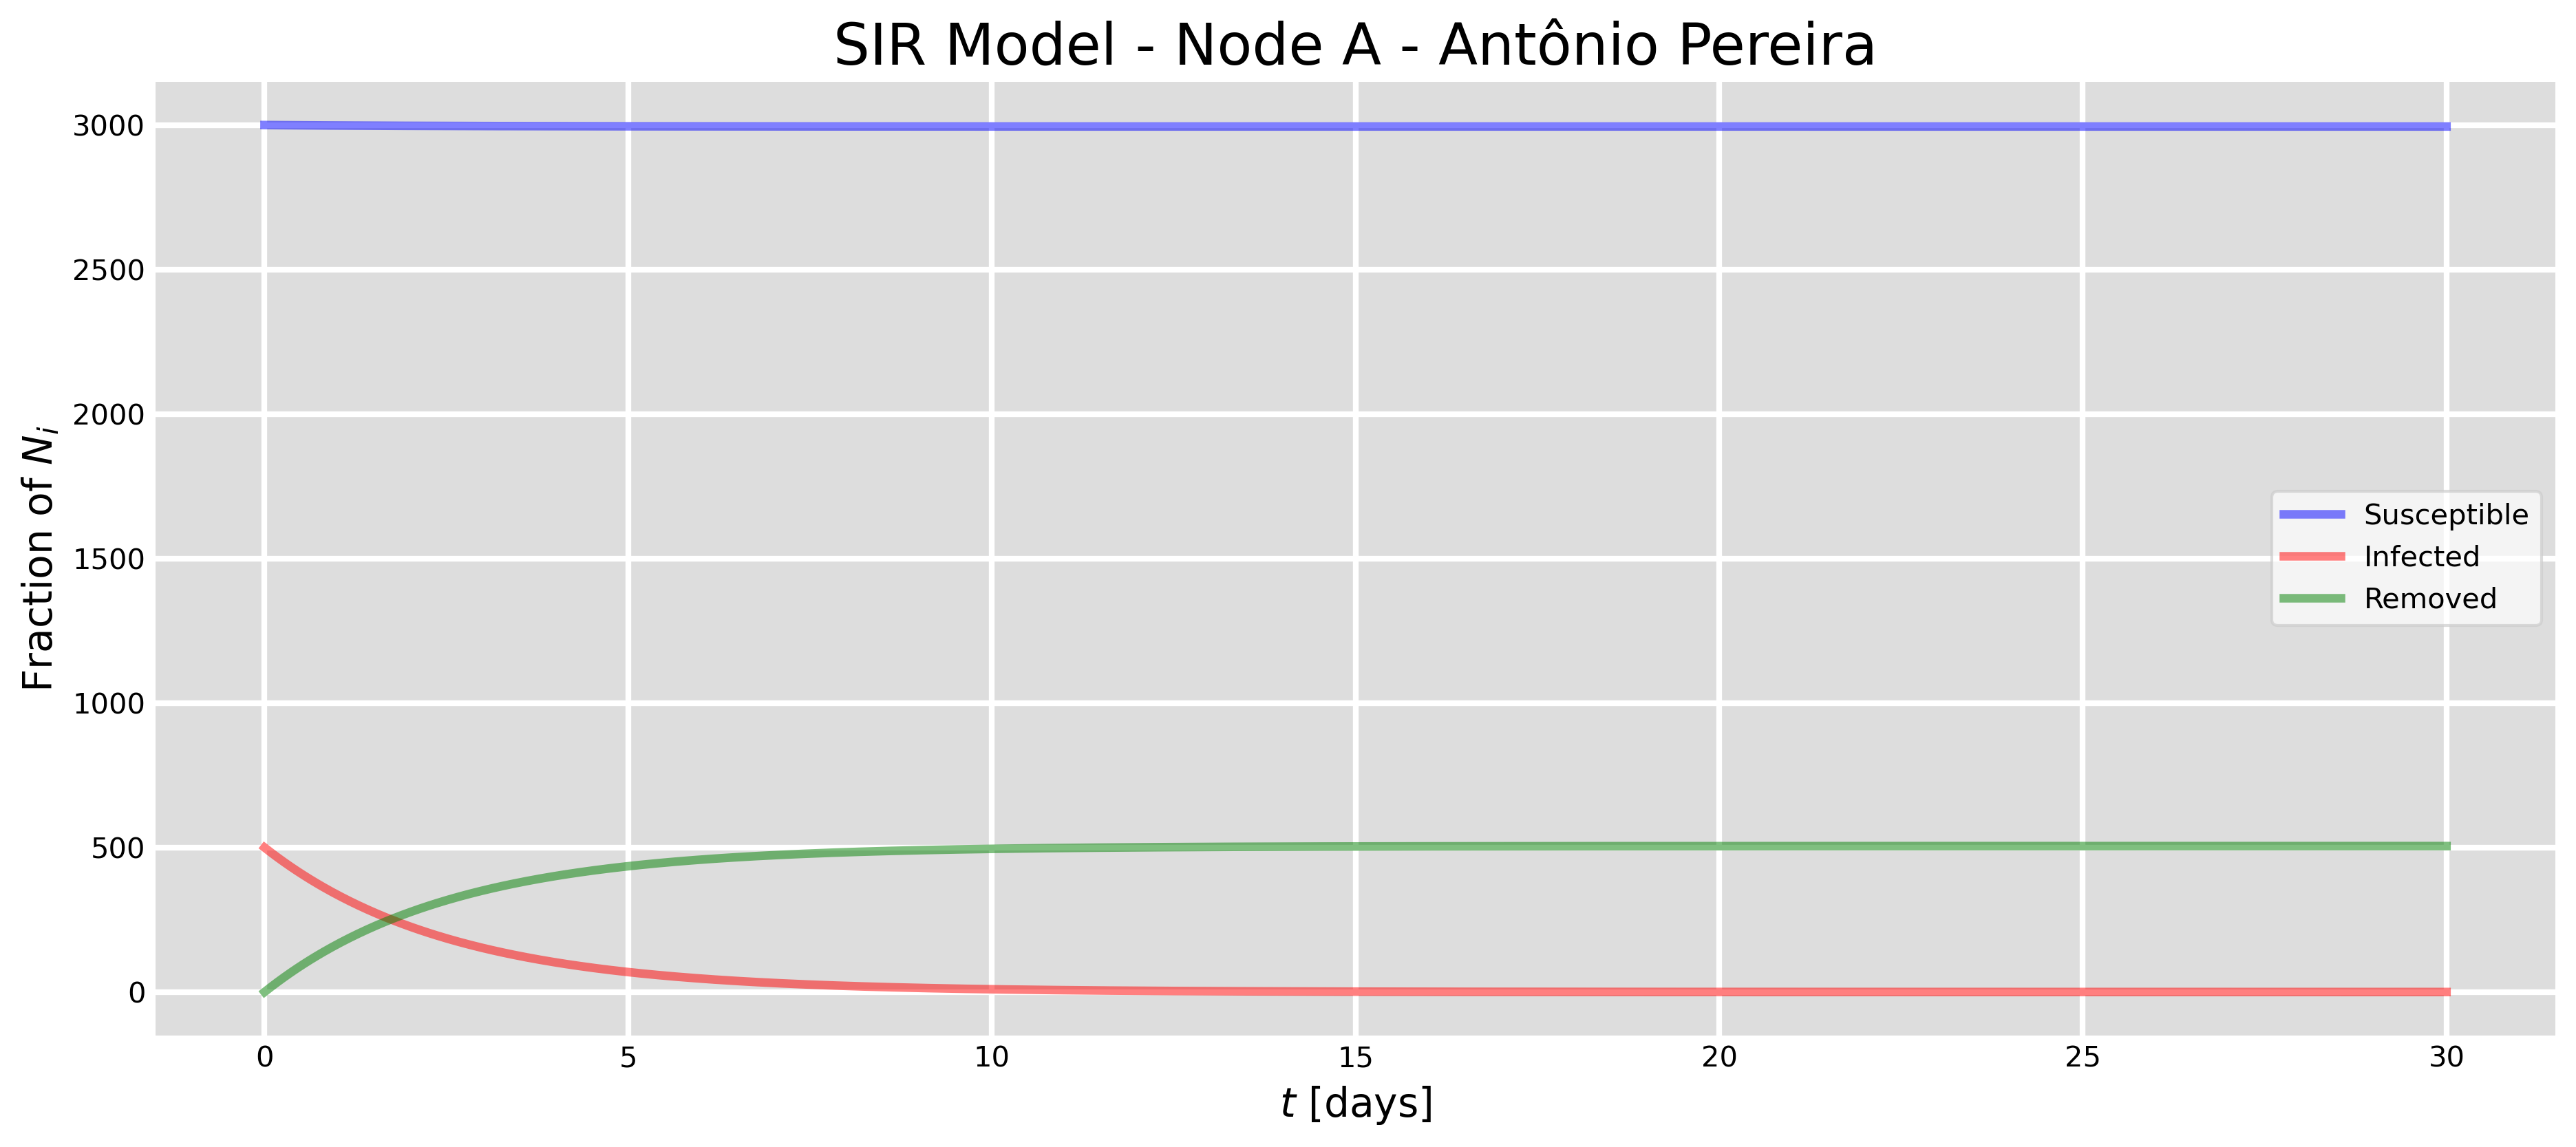

In [147]:
plot_metaSIR(
    t,
    'A',
    {
        'S' : ret[:, [0]],
        'I' : ret[:, [1]],
        'R' : ret[:, [2]]
    }
)

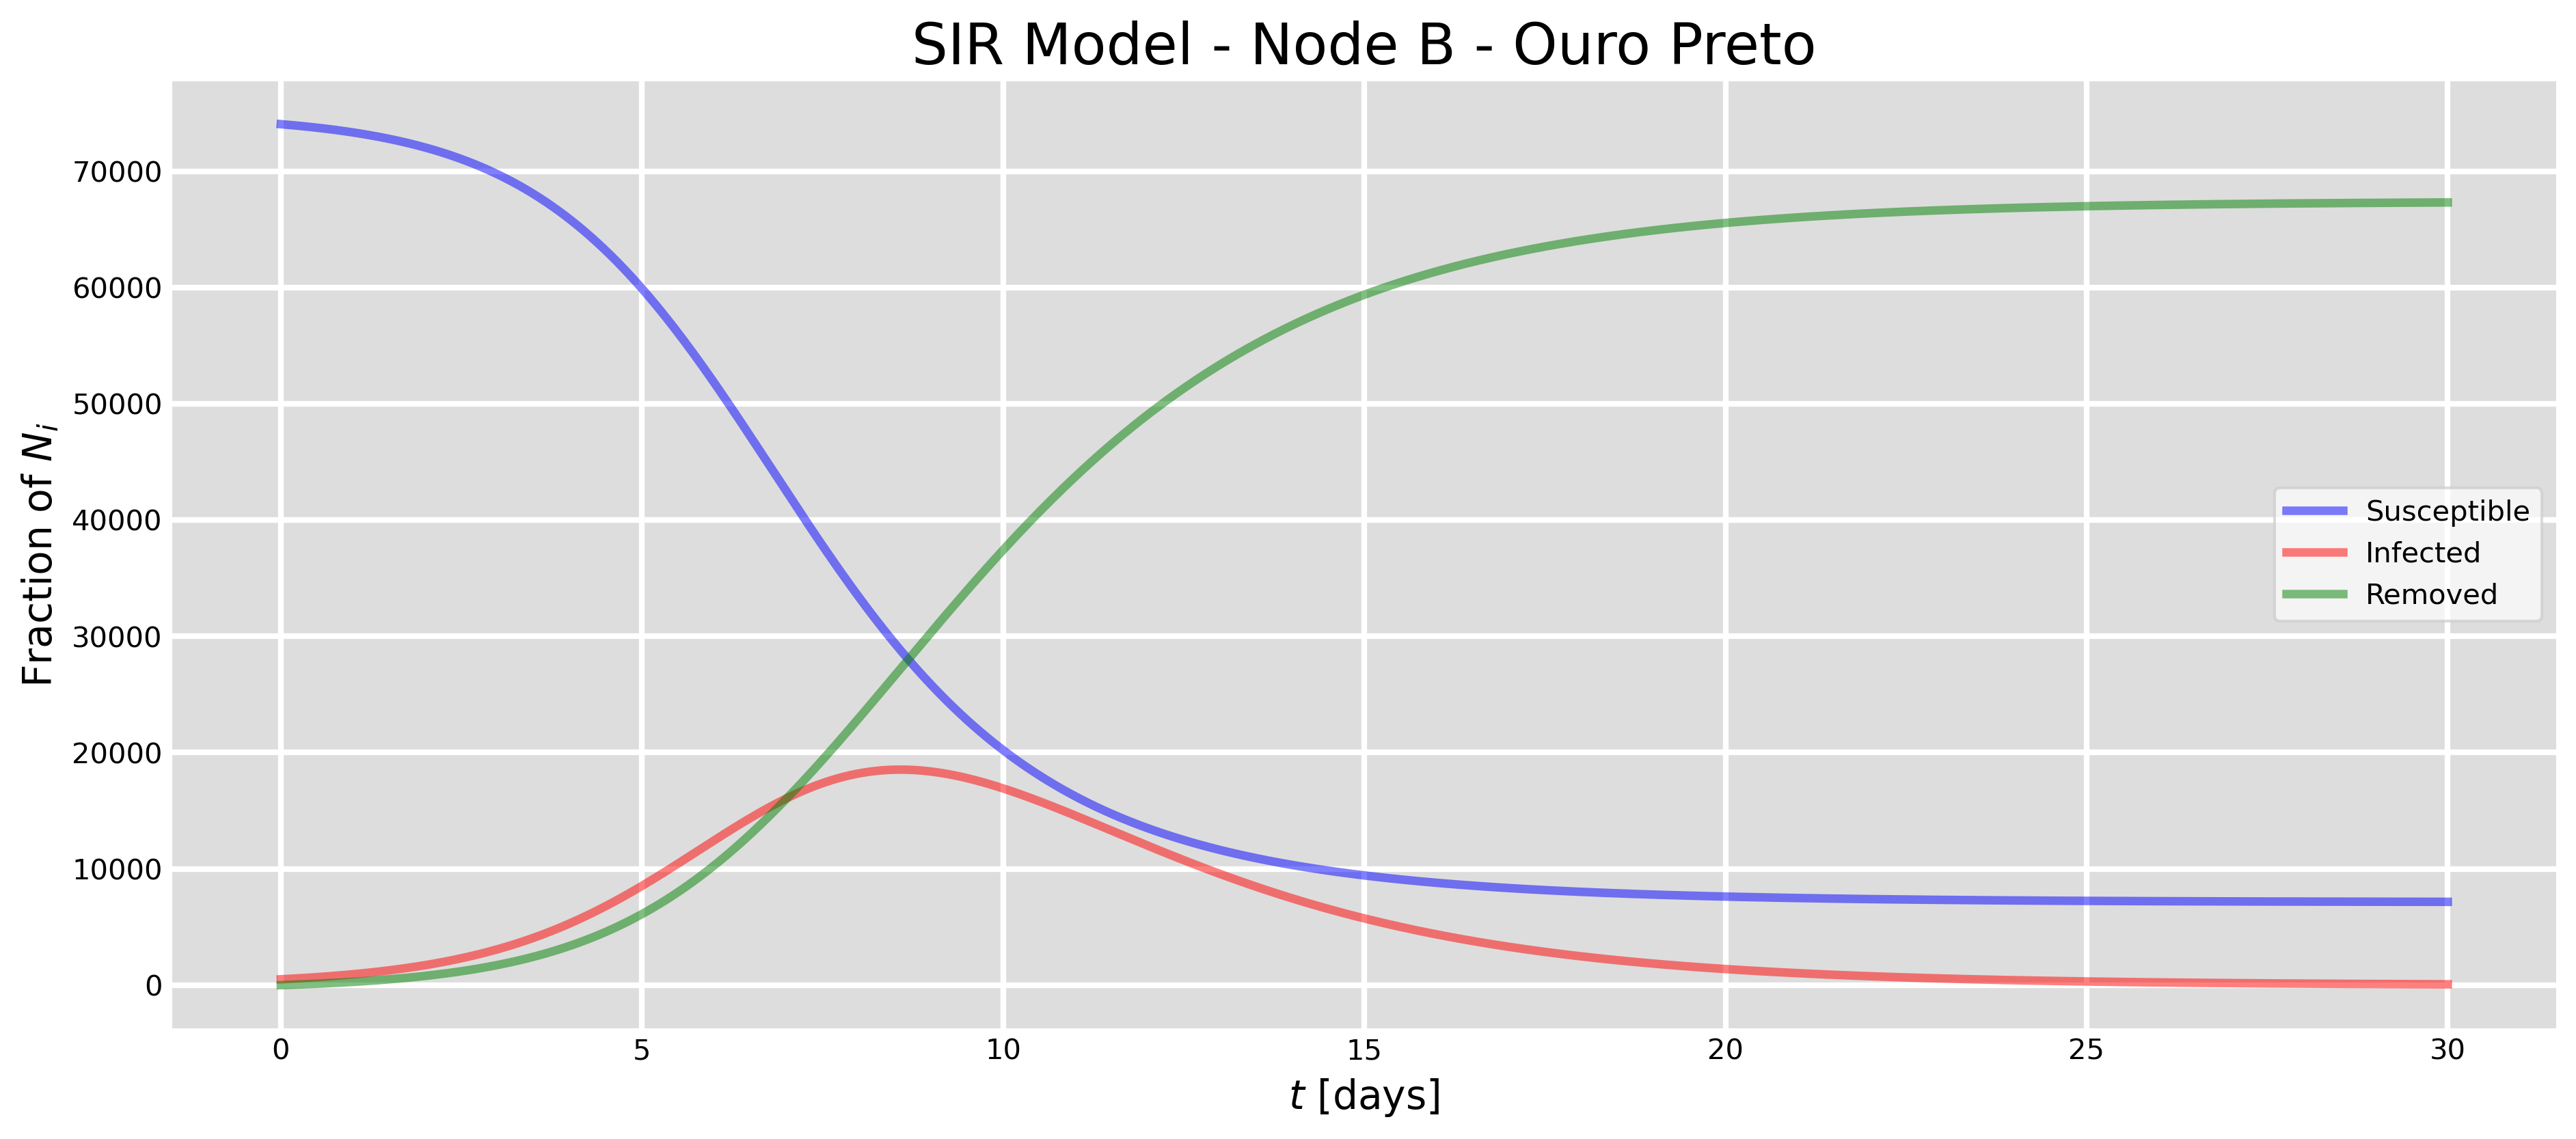

In [148]:
plot_metaSIR(
    t,
    'B',
    {
        'S' : ret[:, [3]],
        'I' : ret[:, [4]],
        'R' : ret[:, [5]]
    }
)

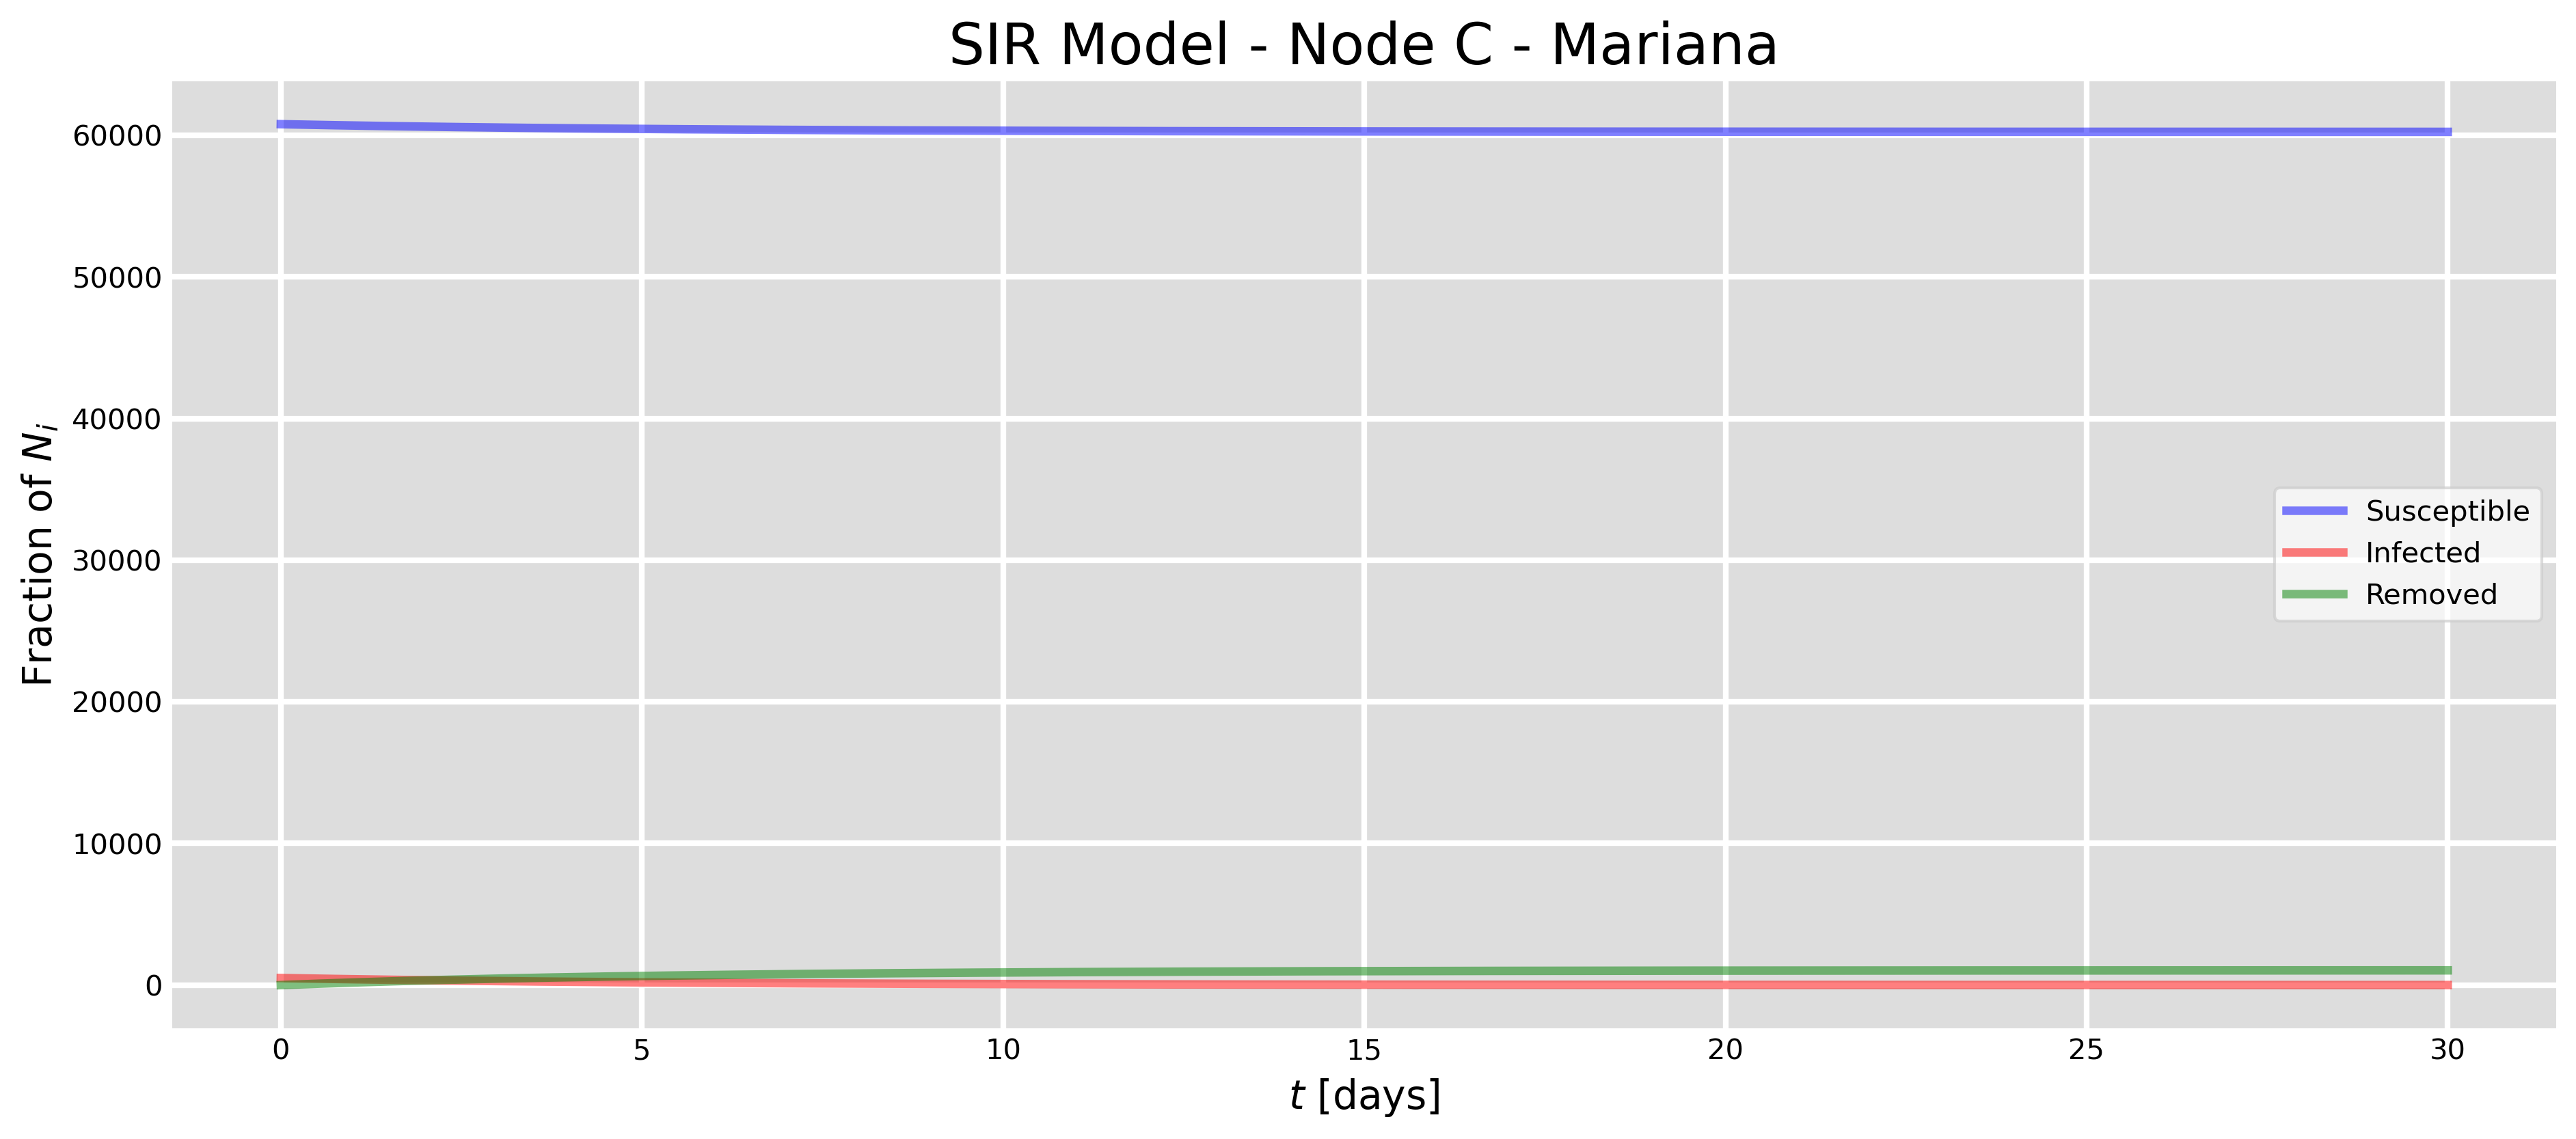

In [149]:
plot_metaSIR(
    t,
    'C',
    {
        'S' : ret[:, [6]],
        'I' : ret[:, [7]],
        'R' : ret[:, [8]]
    }
)